In [ ]:
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
from keras.applications import ResNet101
from keras.preprocessing import image_dataset_from_directory
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!rm -rf "/content/dataset_shortest"
!unzip -q "/content/drive/My Drive/dataset_shortest.zip" -d /content/
dataset_path = "/content/dataset_shortest"

replace /content/dataset_shortest/Head_Movement_Allowed/ (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,  # Your dataset path
    shuffle=True,
    image_size=(128, 128),  # Resize the images to 128x128
    batch_size=16
)

Found 20146 files belonging to 2 classes.


In [ ]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [ ]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(128, 128),
    tf.keras.layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:



resnet_model = ResNet101(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

In [ ]:
resnet_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
    resnet_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(dataset.class_names), activation='softmax')  # Match the number of classes
])

In [ ]:
from keras import mixed_precision

# Set mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Now compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)               │ (None, 4, 4, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,047,554 (194.73 MB)

 Trainable params: 8,389,378 (32.00 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [ ]:

EPOCHS = 50

history = model.fit(
        train_dataset,
        epochs=EPOCHS,  # Train for one epoch
        batch_size= 16,  # Use your batch size
        validation_data=val_dataset

    )




Epoch 1/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 116s 78ms/step - accuracy: 0.9395 - loss: 0.9643 - val_accuracy: 0.9940 - val_loss: 0.0164
Epoch 2/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 77s 39ms/step - accuracy: 0.9867 - loss: 0.0435 - val_accuracy: 0.9861 - val_loss: 0.0359
Epoch 3/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.9842 - loss: 0.0591 - val_accuracy: 0.9940 - val_loss: 0.0142
Epoch 4/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9900 - loss: 0.0411 - val_accuracy: 0.9985 - val_loss: 0.0048
Epoch 5/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9890 - loss: 0.0391 - val_accuracy: 0.9995 - val_loss: 0.0011
Epoch 6/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.9902 - loss: 0.0393 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 7/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9911 - loss: 0.0320 - val_accuracy: 0.9995 - val_loss: 0.0014
Epoch 8/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9953 

In [ ]:
scores = model.evaluate(test_dataset)
scores

126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.9989 - loss: 0.0129


[0.009759644977748394, 0.9990079402923584]

In [ ]:
scoress = model.evaluate(train_dataset)
scoress

1008/1008 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - accuracy: 0.9996 - loss: 0.0016


[0.0019935329910367727, 0.9995035529136658]

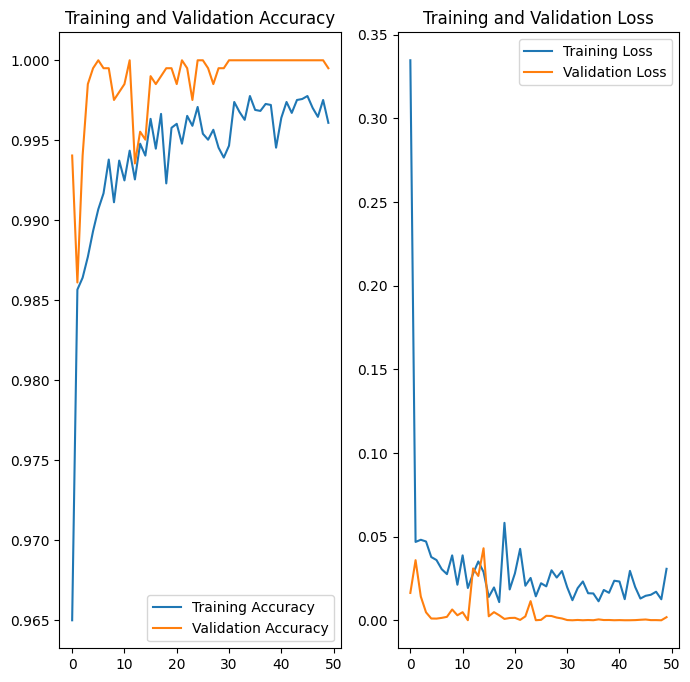

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Actual Label: Head_Movement_Allowed
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted Label: Head_Movement_Allowed


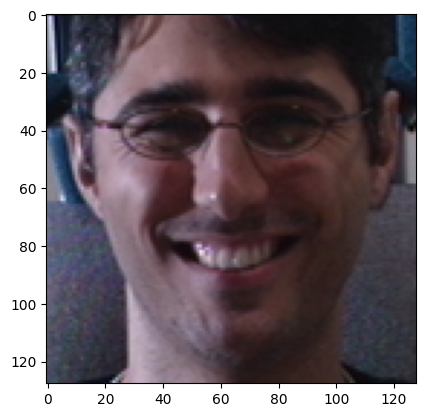

In [ ]:
for img, label in test_dataset.take(1):
    first_image = img[0].numpy().astype("uint8")
    first_label = label[0].numpy()

    plt.imshow(first_image, cmap='gray')
    print(f"Actual Label: {dataset.class_names[first_label]}")

    batch_prediction = model.predict(img)
    predicted_class = np.argmax(batch_prediction[0])
    print(f"Predicted Label: {dataset.class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

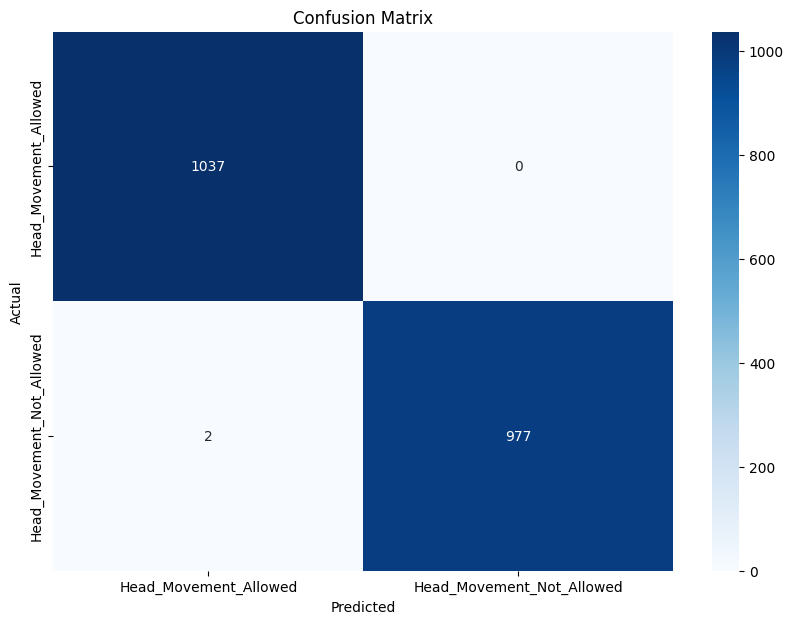

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

for img, label in test_dataset:
    preds = model.predict(img)
    y_true.extend(label.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.class_names, yticklabels=dataset.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Precision: 1.0
Recall: 0.9979570990806946
F1 Score: 0.9989775051124744


In [ ]:
def predict_image(model, img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    #img_array = img_array * (1.0 / 255.0)  # Normalize

    predictions = model.predict(img_array)
    predicted_class = dataset.class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

# Example prediction on a single image
img_path = '/content/drive/MyDrive/Ray2.jpg'  # Replace with your image path
predicted_class, confidence = predict_image(model, img_path)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class: Head_Movement_Allowed, Confidence: 100.0%


In [ ]:
model_version = 'CNN_Model2'
model.save(f"/content/drive/My Drive/{model_version}.keras")
print("Model saved successfully!")

Model saved successfully!
